In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "64"
import healpy as hp
import astropy
from astropy import units as u
import numpy as np
from pathlib import Path
import pysm3 as pysm3
import pysm3.units as u
import pymaster as nmt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import cmasher as cmr

The notebook uses significant memory when executing `NaMaster`, you need to use the "Exclusive CPU node" option on `Jupyter@NERSC`, the "Login node" session crashes.

### accessing data from pysm folder at nersc 

In [2]:
templatedir = Path("/global/cfs/cdirs/cmb/www/pysm-data/")
datadir=  Path("/global/cfs/cdirs/cmb/www/pysm-methods-paper/raw_data/")
maskdir = Path("/global/cfs/cdirs/cmb/www/pysm-methods-paper/masks")
comp = "IQU"
nside = 2048

In [3]:
def run_namaster(m, mask, lmax, nlbins):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """

    nside = hp.npix2nside(len(mask))
    # b = nmt.NmtBin.from_nside_linear(nside, 16)
    # leff = b.get_effective_ells()
    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    if len(m) == 3:
        f_0 = nmt.NmtField(mask, [m[0]])
        f_2 = nmt.NmtField(
            mask, m[1:].copy(), purify_b=True
        )  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))
        f_0 = nmt.NmtField(mask, [m[0]])

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

## read the raw data maps  

In [4]:
synch_data = hp.read_map(
    datadir / "haslam_wmap_Kband_512.fits", field=None
)
dust_data = hp.read_map(
    datadir / "gnilc_353ghz_2048.fits", field=None
)


## read the  pysm3 model templates  

In [5]:

synch_temp = hp.read_map(
    templatedir / "synch/synch_template_nside2048_2023.02.25.fits", field=None
)
dust_temp = hp.read_map(
    templatedir / "dust_gnilc/gnilc_dust_template_nside2048_2023.02.10.fits", field=None
)

In [6]:
synch_data= hp.ud_grade(synch_data, nside_out=nside)
dust_data= hp.ud_grade(dust_data, nside_out=nside)
synch_temp= hp.ud_grade(synch_temp, nside_out=nside)
dust_temp= hp.ud_grade(dust_temp, nside_out=nside )

### reading maps and calling pysm models 

Remark : templates are in uK_RJ 

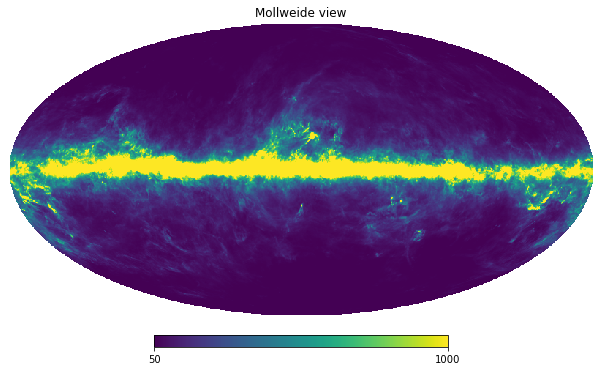

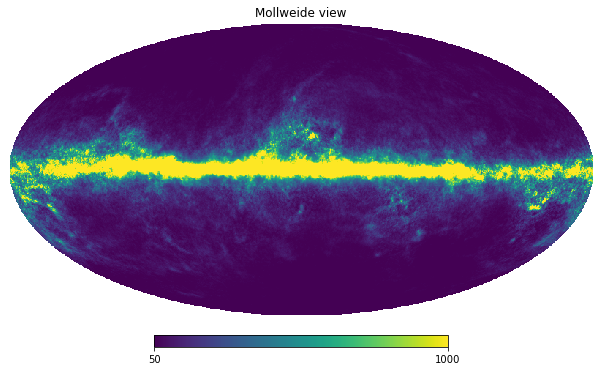

In [31]:
hp.mollview(dust_data[0], min=50,max=1000 )
hp.mollview(dust_temp[0], min=50,max=1000 )

## Reading Planck HFI masks 

In [7]:
planck_mask_filename = maskdir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

In [8]:
planck_masks = {
    "GAL080": hp.ud_grade(
        hp.read_map(planck_mask_filename, ["GAL080"]), nside_out=nside
    ),
    "GAL040": hp.ud_grade(
        hp.read_map(planck_mask_filename, ["GAL040"]), nside_out=nside
    ),
    "GAL020": hp.ud_grade(
        hp.read_map(planck_mask_filename, ["GAL020"]), nside_out=nside
    ),
}

#### Plotting TT, EE, TE, BB Synchrtron spectra for 3 different choices of Planck masks with fsky = 20%, 40%, 80% 

/global/homes/g/giuspugl/software/namaster_nb/lib/python3.8/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


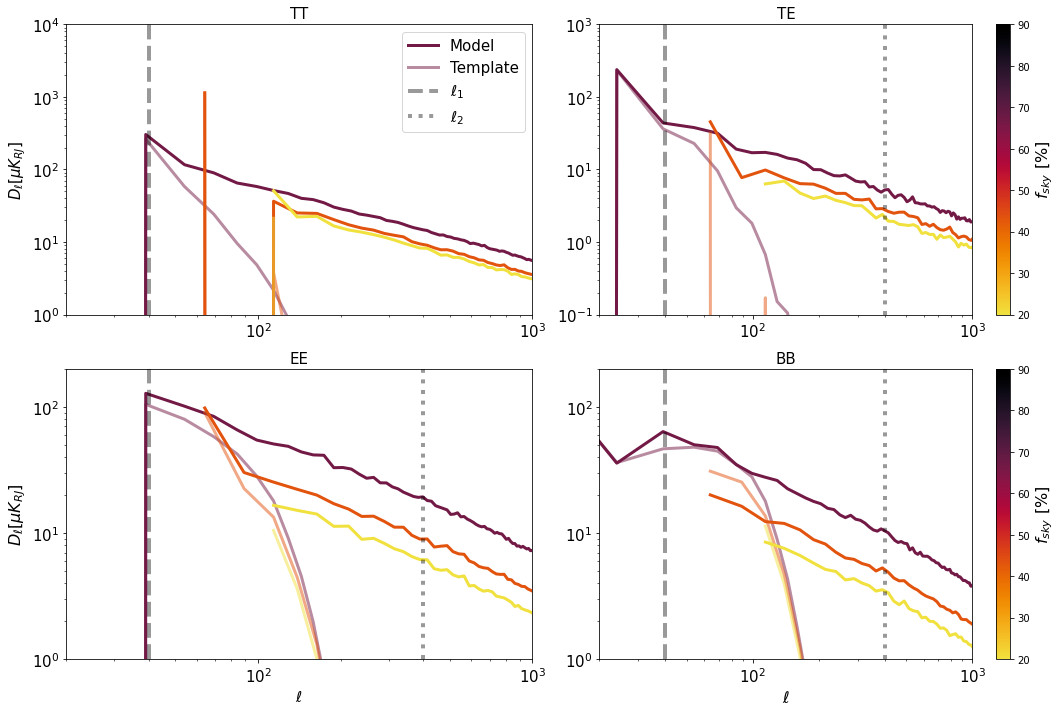

In [10]:
bins = {"GAL080": 15, "GAL040": 25, "GAL020": 25}
xbins = {"GAL080": 1, "GAL040": 4, "GAL020": 6}
lmax = 3000
colors = cmr.ember(np.linspace(0, 1, len(planck_masks.keys()) + 1))
plt.figure(figsize=(15, 10))
sm = plt.cm.ScalarMappable(cmap=cmr.ember_r, norm=plt.Normalize(vmin=20.0, vmax=90))
cb = plt.colorbar(sm)
for jj, k in enumerate(["GAL080", "GAL040", "GAL020"]):
    input_ell, cl_norm, cl_in = run_namaster(
        m=synch_data, mask=planck_masks[k], lmax=lmax, nlbins=bins[k]
    )
    output_ell, cl_norm, cl_out = run_namaster(
        m=synch_temp, mask=planck_masks[k], lmax=lmax, nlbins=bins[k]
    )
    for ii, pol in enumerate(["TT", "TE", "EE", "BB"]):
        plt.subplot(2, 2, ii + 1)
        if jj == 0:
            plt.title(pol, fontsize=15)
            # plt.loglog( ell2,  ell2**2 *(clo [pol]), label='Small-Scales ' ,color=colors[0] ,)
            # plt.loglog( ell,  ell**2 *(cli [pol]),':',   label='GNILC map ',color=colors[0] ,alpha=.3)
            plt.loglog(
                output_ell[xbins[k] :],
                output_ell[xbins[k] :] ** 2 * (cl_out[pol][xbins[k] :]),
                "-",
                label="Model",
                lw=3,
                color=colors[jj + 1],
            )
            # ,label =f"{k}")
            plt.loglog(
                input_ell[xbins[k] :],
                input_ell[xbins[k] :] ** 2 * (cl_in[pol][xbins[k] :]),
                "-",
                lw=3,
                label="Template",
                color=colors[jj + 1],
                alpha=0.5,
            )
        else:
            plt.loglog(
                output_ell[xbins[k] :],
                output_ell[xbins[k] :] ** 2 * (cl_out[pol][xbins[k] :]),
                "-",
                lw=3,
                color=colors[jj + 1],
            )
            # ,label =f"{k}")
            plt.loglog(
                input_ell[xbins[k] :],
                input_ell[xbins[k] :] ** 2 * (cl_in[pol][xbins[k] :]),
                "-",
                lw=3,
                color=colors[jj + 1],
                alpha=0.5,
            )
plt.subplot(221)
plt.axvline(40, 0, 1e4, color="k", lw=4, linestyle="--", alpha=0.4, label=r"$\ell_1$")
plt.axvline(
    400, 1e-12, 1e-4, color="k", lw=4, linestyle=":", alpha=0.4, label=r"$\ell_2$ "
)
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$", fontsize=15)
plt.ylim(1e-0, 1e4)
plt.xlim(20, 1e3)
plt.legend(fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(223)
plt.axvline(40, 0, 1e4, color="k", lw=4, linestyle="--", alpha=0.4)
plt.axvline(400, 0, 1e4, color="k", lw=4, linestyle=":", alpha=0.4, label=r"$\ell_2$")
plt.ylim(1e-0, 2e2)
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$", fontsize=16)
plt.xlabel(("$\ell$"), fontsize=15)
plt.xlim(20, 1e3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

cb.set_label(r" $f_{sky}$ [%]", rotation="vertical", fontsize=16)
plt.subplot(224)
plt.axvline(40, 0, 1e4, color="k", lw=4, linestyle="--", alpha=0.4)
plt.axvline(400, 0, 1e4, color="k", lw=4, linestyle=":", alpha=0.4, label=r"$\ell_2$")

plt.xlabel(("$\ell$"), fontsize=16)
plt.ylim(1e0, 2e2)
plt.xlim(20, 1e3)
sm = plt.cm.ScalarMappable(cmap=cmr.ember_r, norm=plt.Normalize(vmin=20.0, vmax=90))
cb = plt.colorbar(sm)
cb.set_label(r"$f_{sky}$ [%]", rotation="vertical", fontsize=16)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(222)
plt.axvline(40, 0, 1e4, color="k", lw=4, linestyle="--", alpha=0.4)
plt.axvline(400, 0, 1e4, color="k", lw=4, linestyle=":", alpha=0.4, label=r"$\ell_2$")
plt.ylim(1e-1, 1e3)
plt.xlim(20, 1e3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

cb = plt.colorbar(sm)
cb.set_label(r"$f_{sky}$ [%]", rotation="vertical", fontsize=16)
plt.tight_layout()
plt.savefig('../figures/synch_valspectra.pdf' )

#### Plotting TT, EE, TE, BB Dust  spectra for 3 different choices of Planck masks with fsky = 20%, 40%, 80% 

/global/homes/g/giuspugl/software/namaster_nb/lib/python3.8/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


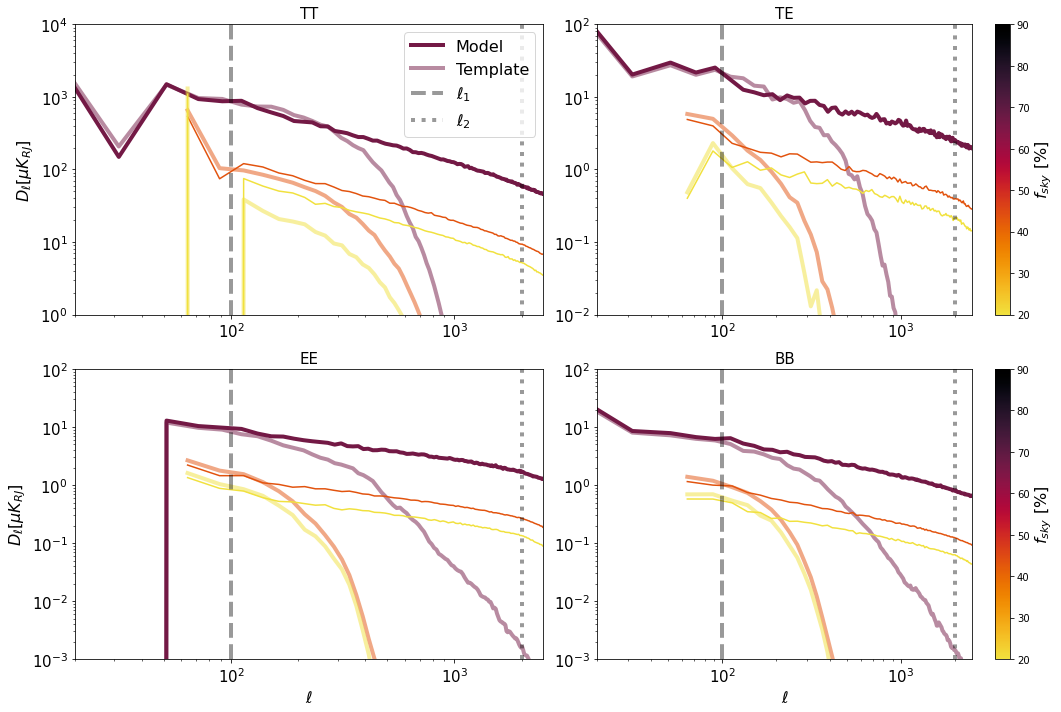

In [11]:
bins = {"GAL080": 20, "GAL040": 25, "GAL020": 25}
xbins = {"GAL080": 1, "GAL040": 4, "GAL020": 4}
lmax = 3000
colors = cmr.ember(np.linspace(0, 1, len(planck_masks.keys()) + 1))
fig = plt.figure(figsize=(15, 10))

grid = AxesGrid(
    fig,
    111,
    nrows_ncols=(2, 2),
    axes_pad=0.05,
    cbar_mode="single",
    cbar_location="right",
    cbar_pad=0.1,
)


for jj, k in enumerate(["GAL080", "GAL040", "GAL020"]):
    input_ell, cl_norm, cl_in = run_namaster(
        m=dust_data, mask=planck_masks[k], lmax=lmax, nlbins=bins[k]
    )

    output_ell, cl_norm, cl_out = run_namaster(
        m=dust_temp, mask=planck_masks[k], lmax=lmax, nlbins=bins[k]
    )
    for ii, pol in enumerate(["TT", "TE", "EE", "BB"]):
        plt.subplot(2, 2, ii + 1)
        if jj == 0:
            plt.title(pol, fontsize=15)
            plt.loglog(
                output_ell[xbins[k] :],
                output_ell[xbins[k] :] ** 2 * (cl_out[pol][xbins[k] :]),
                "-",
                color=colors[jj + 1],
                label="Model",lw=4 
            )
            plt.loglog(
                input_ell[xbins[k] :],
                input_ell[xbins[k] :] ** 2 * (cl_in[pol][xbins[k] :]) / 1.3,
                "-",
                lw=4,
                color=colors[jj + 1],
                alpha=0.5,
                label="Template",
            )
        else:
            plt.loglog(
                output_ell[xbins[k] :],
                output_ell[xbins[k] :] ** 2 * (cl_out[pol][xbins[k] :]),
                "-",
                color=colors[jj + 1],
            )
            plt.loglog(
                input_ell[xbins[k] :],
                input_ell[xbins[k] :] ** 2 * (cl_in[pol][xbins[k] :]),
                "-",
                lw=4,
                color=colors[jj + 1],
                alpha=0.5,
            )

     
plt.subplot(221)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.axvline(100, 0, 1e7, color="k", lw=4, linestyle="--", alpha=0.4, label=r"$\ell_1$")
plt.axvline(
    2000, 0, 1e7, color="k", lw=4, linestyle=":", alpha=0.4, label=r"$\ell_2$ "
)
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$", fontsize=16)
plt.ylim(1e0, 1e4)
plt.xlim(20, 2.5e3)
plt.legend(fontsize=16)
plt.subplot(223)
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$", fontsize=16)
plt.xlabel(("$\ell$"), fontsize=16)
plt.axvline(
    100,
    0,
    1e7,
    color="k",
    lw=4,
    linestyle="--",
    alpha=0.4,
    label=r"$\ell_1$" + "small scales",
)
plt.axvline(
    2000,
    0,
    1e7,
    color="k",
    lw=4,
    linestyle=":",
    alpha=0.4,
    label=r"$\ell_2$ " + "small scales",
)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(1e-3, 1e2)
plt.xlim(20, 2.5e3)
sm = plt.cm.ScalarMappable(cmap=cmr.ember_r, norm=plt.Normalize(vmin=20.0, vmax=90))

# cb.set_label(r' $f_{sky}$ [%]' ,rotation='90', fontsize=16 )
plt.subplot(224)
plt.axvline(
    100,
    0,
    1e7,
    color="k",
    lw=4,
    linestyle="--",
    alpha=0.4,
    label=r"$\ell_1$" + "small scales",
)
plt.axvline(
    2000,
    0,
    1e7,
    color="k",
    lw=4,
    linestyle=":",
    alpha=0.4,
    label=r"$\ell_2$ " + "small scales",
)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cb = plt.colorbar(sm)
cb.set_label(r"$f_{sky}$ [%]", rotation="vertical", fontsize=16)

plt.xlabel(("$\ell$"), fontsize=16)
plt.ylim(1e-3, 1e2)
plt.xlim(20, 2.5e3)

plt.subplot(222)
plt.axvline(
    100,
    0,
    1e7,
    color="k",
    lw=4,
    linestyle="--",
    alpha=0.4,
    label=r"$\ell_1$" + "small scales",
)
plt.axvline(
    2000,
    0,
    1e7,
    color="k",
    lw=4,
    linestyle=":",
    alpha=0.4,
    label=r"$\ell_2$ " + "small scales",
)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(1e-2, 1e2)
plt.xlim(20, 2.5e3)


plt.tight_layout()
cb = fig.colorbar(sm)
cb.set_label(r"$f_{sky}$ [%]", rotation="vertical", fontsize=16)
plt.savefig('../figures/dust_valspectra.pdf' )